## Density - Based Clustering
### DBSCAN Algorithm Implementation 

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
pd.set_option('display.max_rows', 600)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
def datatrans(filename, seperator):
    df = pd.read_csv(filename, header=None,sep=seperator)
    new_df = df.drop(axis = 1, columns = [0,1])
    df_array = new_df.to_numpy()
    dist_mat = squareform(pdist(df_array, 'euclidean'))
    data = new_df.copy()
    data.columns = list(range(new_df.shape[1]))
    data["Cluster"] = 0
    data["Visited"] = 0
    return [dist_mat, data, df]

In [3]:
def clusterupdate(NeighPts, C, data):
    for i in NeighPts:
        data.loc[i, "Cluster"] = C

In [4]:
def regionQuery(p, eps, dist_mat):
    points = []
    for i in range(len(dist_mat[p])):
        if dist_mat[p][i] <= eps:
            points.append(i)
    return list(set(points))

In [5]:
def expandCluster(index, NeighPts, C, eps, minpts, data, dist_mat):
    data.loc[index, "Cluster"] = C
    for p in NeighPts:
        if data.loc[p, "Visited"] == 0:
            data.loc[p, "Visited"] = 1
            NeighPts_ = regionQuery(p, eps, dist_mat)
            if len(NeighPts_) >= minpts:
                NeighPts += NeighPts_   
                NeighPts = list(set(NeighPts))
                clusterupdate(NeighPts, C, data)
            else:
                data.loc[p, "Cluster"] = "Noise"
        if data.loc[p, "Cluster"] == 0:
            data.loc[p, "Cluster"] = C

In [6]:
def DBSCAN(filename, eps, minpts, seperator):
    C = 0
    dist_mat = datatrans(filename, seperator)[0]
    data = datatrans(filename, seperator)[1]
    df = datatrans(filename, seperator)[2]
    for index in range(len(data)):
        if data.loc[index, "Visited"] == 0:
            data.loc[index, "Visited"] = 1
            NeighPts = regionQuery(index, eps, dist_mat)
            if len(NeighPts) < minpts:
                data.loc[index, "Cluster"] = "Noise"
            else:
                C += 1
                expandCluster(index, NeighPts, C, eps, minpts, data, dist_mat)
    data = data.drop(axis = 1, columns = ["Visited"])
    data["Ground_Truth"] = df[1]
    return data

In [7]:
# Clustering Validation
def jac_rand(ground_cluster, cluster_gen):

    cluster1, cluster2 = ground_cluster, cluster_gen
    m_1_1=0
    m_0_0=0
    m_0_1=0
    m_1_0=0

    inc_m_g = np.empty([len(ground_cluster),len(ground_cluster)])
    inc_m_c = np.empty([len(ground_cluster),len(ground_cluster)])

    for i in range(len(ground_cluster)):
        for j in range(len(ground_cluster)):
            inc_m_g[i,j] = 1 if cluster1[i]==cluster1[j] else 0
            inc_m_c[i,j] = 1 if cluster2[i]==cluster2[j] else 0
            if inc_m_g[i,j]==1 and inc_m_c[i,j]==1:
                m_1_1+=1
            elif inc_m_g[i,j]==0 and inc_m_c[i,j]==0:
                m_0_0+=1
            elif inc_m_g[i,j]==1 and inc_m_c[i,j]==0:
                m_1_0+=1
            else:
                m_0_1+=1
    jaccard = m_1_1/(m_1_1 + m_0_1 + m_1_0)
    rand = (m_1_1 + m_0_0)/(m_1_1 + m_0_1 + m_1_0 + m_0_0)
    return [jaccard, rand]

In [8]:
def pca_inbuilt(file):
    target = file["Cluster"]
    inputs_copy = file.drop(['Cluster', 'Ground_Truth'], axis='columns')
    pca = PCA(n_components=2)
    pca_dim = pca.fit_transform(inputs_copy.to_numpy())
    pca_df = pd.DataFrame(pca_dim)
    pca_df.rename(columns = {0:'PCA_1',1:'PCA_2'}, inplace = True)
    pca_df["Target"] = target
    labels = set(pca_df['Target'])
    plt.figure(figsize = (12,12))
    for label in labels:
        index = pca_df['Target'] == label
        plt.plot(pca_df['PCA_1'][index], pca_df['PCA_2'][index],linestyle='none', marker='o', label=label)
        plt.xlabel('PCA_1', fontsize=18)
        plt.ylabel('PCA_2', fontsize=18)
    plt.legend(numpoints=1, fontsize=18)
    plt.title("PCA", fontsize=18)
    plt.show()

In [9]:
def plot(file):
    target = file["Cluster"]
    inputs = file.drop(['Cluster', 'Ground_Truth'], axis='columns')
    inputs.rename(columns = {0:'Axis_1',1:'Axis_2'}, inplace = True)
    inputs["Target"] = target
    labels = set(inputs['Target'])
    plt.figure(figsize = (12,12))
    for label in labels:
        index = inputs['Target'] == label
        plt.plot(inputs['Axis_1'][index], inputs['Axis_2'][index],linestyle='none', marker='o', label=label)
        plt.xlabel('Axis_1', fontsize=18)
        plt.ylabel('Axis_2', fontsize=18)
    plt.legend(numpoints=1, fontsize=18)
    plt.title("Cluster Plot", fontsize=18)
    plt.show()

**Run the below cell and give the necessary inputs.**


**Note: Use appropriate strings for separation, eg: "\t" for tab space and "\s+" for single space.**

Enter the name of the file: dbscan.txt
Enter the seperator: \s+
Enter the epsilon value : 0.5
Enter the minimum points value : 5
For DBSCAN on dbscan.txt with eps as 0.5 and min points as 5:
Jaccard :  0.27295668095420467
Rand :  0.7709404958677686


Plot for the file dbscan.txt


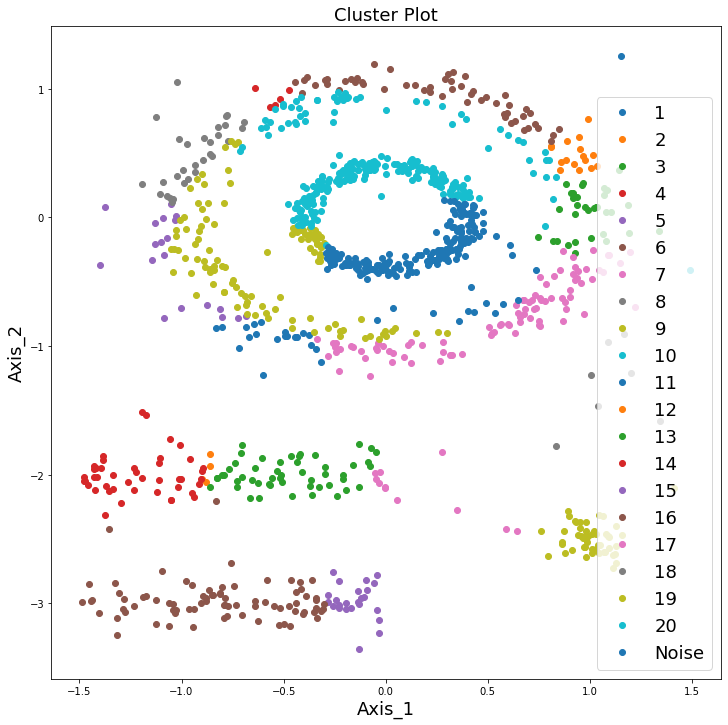

In [12]:
file_name = input('Enter the name of the file: ')
seperator = str(input('Enter the seperator: '))
eps = float(input('Enter the epsilon value : '))
minpts = int(input('Enter the minimum points value : '))
data = DBSCAN(file_name, eps, minpts, seperator)
jac, rand = jac_rand(data["Ground_Truth"], data["Cluster"])
print("For DBSCAN on "+file_name+" with eps as "+str(eps)+ " and min points as "+str(minpts)+":")
print('Jaccard : ',jac)
print('Rand : ',rand)
print("\n")
print("Plot for the file "+file_name)
if data.shape[1]-2 > 2:
    pca_inbuilt(data)
else:
    plot(data)

In [11]:
data

,0,1,Cluster,Ground_Truth
0,-0.803739,-0.853053,1,1
1,0.852851,0.367618,2,1
2,0.927180,-0.274902,2,1
3,-0.752626,-0.511565,3,1
4,0.706846,0.810679,3,1
...,...,...,...,...
1095,0.956063,-2.473828,Noise,6
1096,0.930758,-2.366531,6,6
1097,0.989555,-2.475225,Noise,6
1098,0.979200,-2.637578,Noise,6
